In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

from kalman_experiments.kalman import Colored1DMatsudaKF
from kalman_experiments.noise import ArNoise, prepare_real_noise
from kalman_experiments.models import SingleRhythmModel
from kalman_experiments.cfir import CFIRBandDetector
from kalman_experiments.complex import complex2mat, vec2complex
from kalman_experiments.metrics import plv, env_cor

# Simulated AR noise
Parameter A in the code below corresponds to A in Matsuda's model:
$$x_{k+1} = A e^{\frac{2 \pi i f}{sr}} x_k + \nu, \nu \sim N(0, \sigma ^ 2)$$

<IPython.core.display.Javascript object>


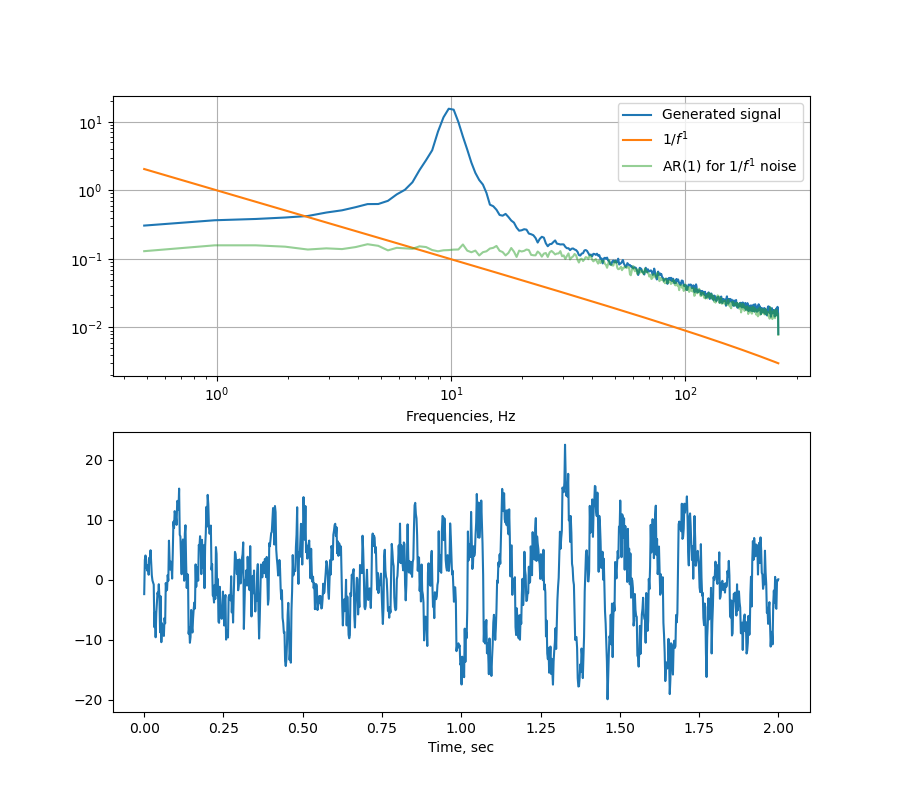

In [2]:
srate = 500
oscillation_freq = 10
A = 0.99          # as in x_next = A*exp(2*pi*oscillation_freq / sr)
signal_sigma = 1  # std of the model-driving white noise in the Matsuda model
noise_ar_order = 1
alpha = 1
noise_sigma = 3  # std of white noise driving the ar model for the colored noise

meas_noise = ArNoise(y0=np.random.rand(noise_ar_order), alpha=alpha, order=noise_ar_order, sigma=noise_sigma)
model = SingleRhythmModel(freq=oscillation_freq, A=A, sigma=signal_sigma, sr=srate, meas_noise=meas_noise)

n_samp = 100_000
noise_samples = np.array([meas_noise.step() for _ in range(n_samp)])
freqs, psd_noise = welch(noise_samples, fs=srate, nperseg=1024)
sig_samples = np.array([model.step() for _ in range(n_samp)])
freqs, psd_signal = welch(sig_samples, fs=srate, nperseg=1024)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 8))
freq_lim = 1000
ax1.loglog(freqs[1:freq_lim], psd_signal[1:freq_lim])
ax1.loglog(freqs[1:freq_lim], [1 / f**alpha - 0.001 for f in freqs[1:freq_lim]])
ax1.loglog(freqs[1:freq_lim], psd_noise[1:freq_lim], alpha=0.5)

ax1.legend([f"AR({noise_ar_order}) for 1/f noise", "1/f", "noise"])
ax1.legend(["Generated signal", f"$1/f^{ {alpha} }$", f"AR({noise_ar_order})" f" for $1/f^{ {alpha} }$ noise"])
ax1.set_xlabel("Frequencies, Hz")
ax1.grid()
ax2.plot(np.linspace(0, 2, 1000), sig_samples[:1000])
ax2.set_xlabel("Time, sec")

plt.show()

<IPython.core.display.Javascript object>


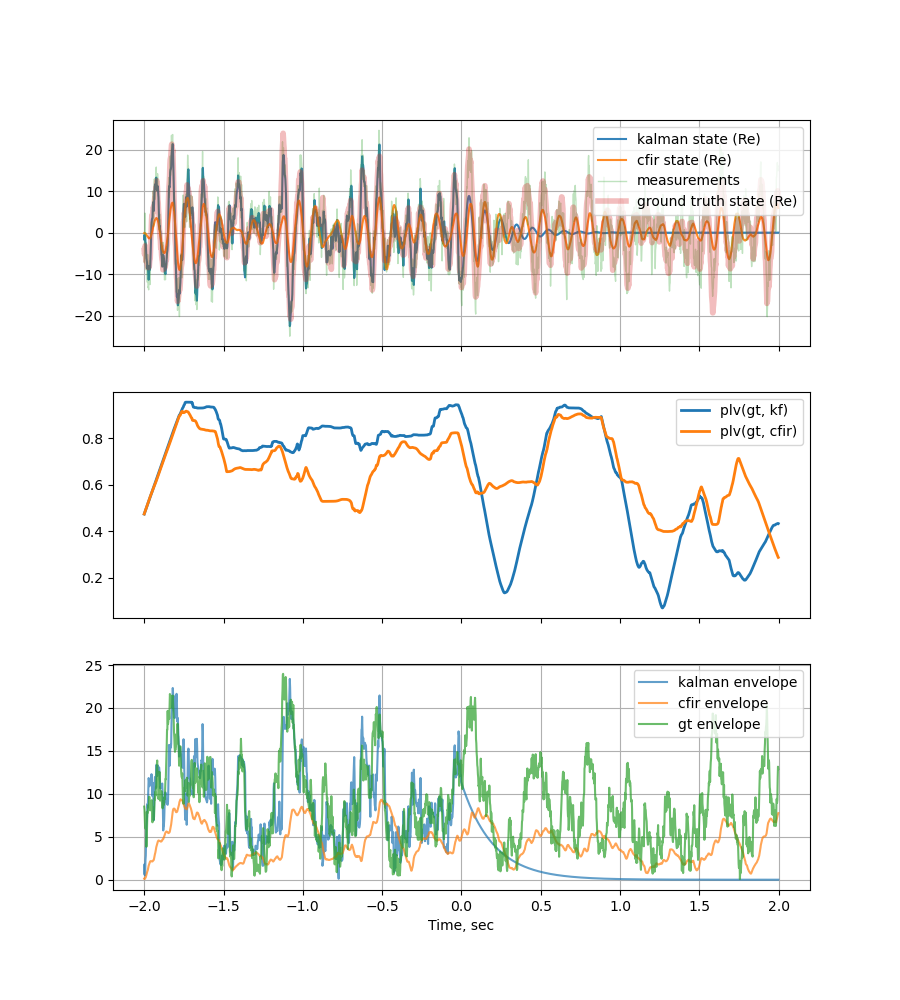

np.abs(plv_tot_kf)=0.8405376726312315, np.abs(plv_tot_cfir)=0.7080179765071459


In [3]:
track_nsamp, predict_nsamp = 1000, 1000

kf = Colored1DMatsudaKF(A=A, f=oscillation_freq, sr=srate, q_sigma=signal_sigma, psi=-0.5, r_sigma=noise_sigma) 

gt_states = []
kf_states = []
meas = []
for i in range(track_nsamp):
    y = model.step()
    gt_states.append(model.x)
    meas.append(y)
    kf_states.append(vec2complex(kf.step(y).mu))
for i in range(predict_nsamp):
    y = model.step()
    gt_states.append(model.x)
    kf_states.append(vec2complex(kf.step(None).mu))
    meas.append(y)
gt_states = np.array(gt_states)
kf_states = np.array(kf_states)
meas = np.array(meas)

cfir = CFIRBandDetector([8, 12], srate, delay=0)
cfir_states = cfir.apply(meas)

t = np.arange(-track_nsamp, predict_nsamp) / srate
f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(9, 10))
ax1.plot(t, np.real(kf_states), alpha=0.9)
ax1.plot(t, np.real(cfir_states), alpha=0.9)
ax1.plot(t, meas, alpha=0.3, linewidth=1)
ax1.plot(t, np.real(gt_states), "-", alpha=0.3, linewidth=4)
ax1.legend(["kalman state (Re)", "cfir state (Re)", "measurements", "ground truth state (Re)"])
ax1.grid()

plt.xlabel("Time, sec")
plv_win_kf, plv_tot_kf = plv(gt_states.copy(), kf_states.copy(), int(0.5 * srate))
plv_win_cfir, plv_tot_cfir = plv(gt_states.copy(), cfir_states.copy(), int(0.5 * srate))
envcor_win_kf, envcor_tot_kf = env_cor(gt_states.copy(), kf_states.copy(), int(0.5 * srate))
envcor_win_cfir, envcor_tot_cfir = env_cor(gt_states.copy(), cfir_states.copy(), int(0.5 * srate))
ax2.plot(t, np.abs(plv_win_kf), linewidth=2)
ax2.plot(t, np.abs(plv_win_cfir), linewidth=2)
ax2.legend(["plv(gt, kf)", "plv(gt, cfir)"])
plt.grid()

ax3.plot(t, np.abs(kf_states), alpha=0.7)
ax3.plot(t, np.abs(cfir_states), alpha=0.7)
ax3.plot(t, np.abs(gt_states), alpha=0.7)
ax3.legend(["kalman envelope", "cfir envelope", "gt envelope"])
plt.show()
print(f"{np.abs(plv_tot_kf)=}, {np.abs(plv_tot_cfir)=}")

# Real noise

Extracting parameters from ../data/ds004148/sub-01/ses-session2/eeg/sub-01_ses-session2_task-eyesopen_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 16501 samples (33.002 sec)

dm= -1.8637033749168618e-17


<IPython.core.display.Javascript object>


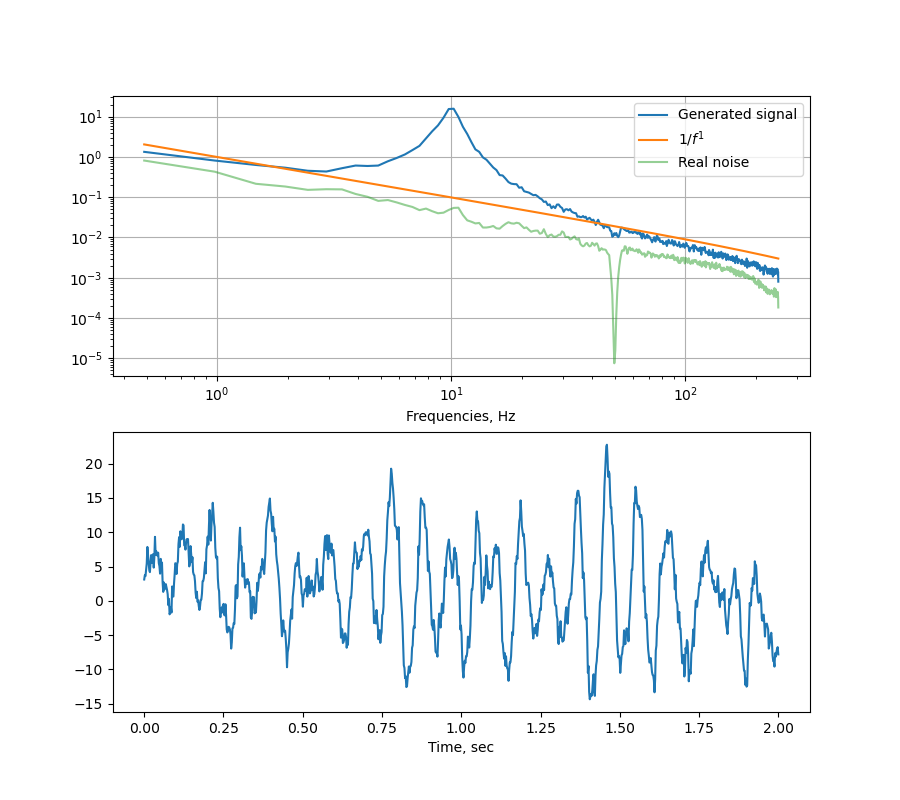

In [29]:
oscillation_freq = 10
A = 0.99          # as in x_next = A*exp(2*pi*oscillation_freq / sr)
signal_sigma = 1  # std of the model-driving white noise in the Matsuda model
noise_sigma = 3  # std of white noise driving the ar model for the colored noise
raw_path = "../data/ds004148/sub-01/ses-session2/eeg/sub-01_ses-session2_task-eyesopen_eeg.vhdr"

real_noise, srate = prepare_real_noise(raw_path=raw_path, sigma=noise_sigma)
model = SingleRhythmModel(freq=oscillation_freq, A=A, sigma=signal_sigma, sr=srate, meas_noise=real_noise)

n_samp = 50_000
noise_samples = np.array([real_noise.step() for _ in range(n_samp)])
freqs, psd_noise = welch(noise_samples, fs=srate, nperseg=1024)
sig_samples = np.array([model.step() for _ in range(n_samp)])
freqs, psd_signal = welch(sig_samples, fs=srate, nperseg=1024)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 8))
freq_lim = 1000
ax1.loglog(freqs[1:freq_lim], psd_signal[1:freq_lim])
ax1.loglog(freqs[1:freq_lim], [1 / f**alpha - 0.001 for f in freqs[1:freq_lim]])
ax1.loglog(freqs[1:freq_lim], psd_noise[1:freq_lim], alpha=0.5)

ax1.legend([f"AR({noise_ar_order}) for 1/f noise", "1/f", "noise"])
ax1.legend(["Generated signal", f"$1/f^{ {alpha} }$", "Real noise"])
ax1.set_xlabel("Frequencies, Hz")
ax1.grid()
ax2.plot(np.linspace(0, 2, 1000), sig_samples[:1000])
ax2.set_xlabel("Time, sec")

plt.show()

<IPython.core.display.Javascript object>


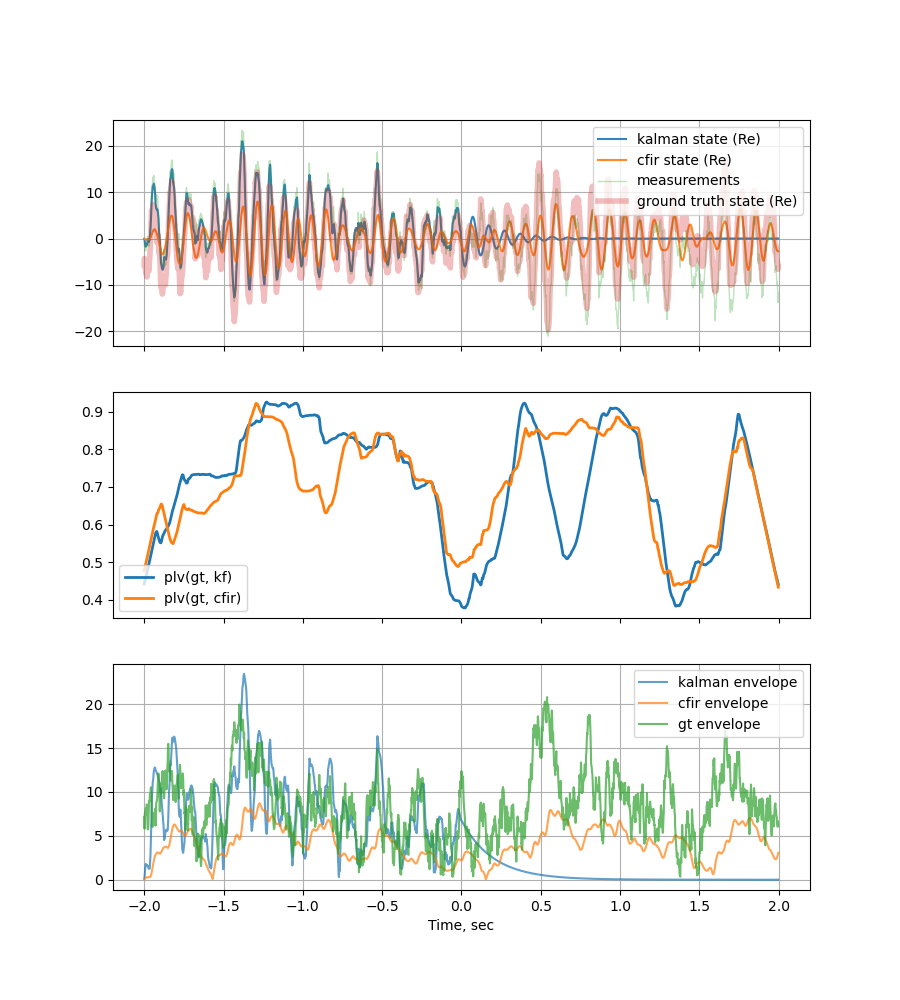

np.abs(plv_tot_kf)=0.7904669462763683, np.abs(plv_tot_cfir)=0.7170625029116908


In [30]:
track_nsamp, predict_nsamp = 1000, 1000

kf = Colored1DMatsudaKF(A=A, f=oscillation_freq, sr=srate, q_sigma=signal_sigma, psi=0, r_sigma=noise_sigma) 

gt_states = []
kf_states = []
meas = []
for i in range(track_nsamp):
    y = model.step()
    gt_states.append(model.x)
    meas.append(y)
    kf_states.append(vec2complex(kf.step(y).mu))
for i in range(predict_nsamp):
    y = model.step()
    gt_states.append(model.x)
    kf_states.append(vec2complex(kf.step(None).mu))
    meas.append(y)
gt_states = np.array(gt_states)
kf_states = np.array(kf_states)
meas = np.array(meas)

cfir = CFIRBandDetector([8, 12], srate, delay=0)
cfir_states = cfir.apply(meas)

t = np.arange(-track_nsamp, predict_nsamp) / srate
f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(9, 10))
ax1.plot(t, np.real(kf_states), alpha=0.9)
ax1.plot(t, np.real(cfir_states), alpha=0.9)
ax1.plot(t, meas, alpha=0.3, linewidth=1)
ax1.plot(t, np.real(gt_states), "-", alpha=0.3, linewidth=4)
ax1.legend(["kalman state (Re)", "cfir state (Re)", "measurements", "ground truth state (Re)"])
ax1.grid()

plt.xlabel("Time, sec")
plv_win_kf, plv_tot_kf = plv(gt_states.copy(), kf_states.copy(), int(0.5 * srate))
plv_win_cfir, plv_tot_cfir = plv(gt_states.copy(), cfir_states.copy(), int(0.5 * srate))
envcor_win_kf, envcor_tot_kf = env_cor(gt_states.copy(), kf_states.copy(), int(0.5 * srate))
envcor_win_cfir, envcor_tot_cfir = env_cor(gt_states.copy(), cfir_states.copy(), int(0.5 * srate))
ax2.plot(t, np.abs(plv_win_kf), linewidth=2)
ax2.plot(t, np.abs(plv_win_cfir), linewidth=2)
ax2.legend(["plv(gt, kf)", "plv(gt, cfir)"])
plt.grid()

ax3.plot(t, np.abs(kf_states), alpha=0.7)
ax3.plot(t, np.abs(cfir_states), alpha=0.7)
ax3.plot(t, np.abs(gt_states), alpha=0.7)
ax3.legend(["kalman envelope", "cfir envelope", "gt envelope"])
plt.show()
print(f"{np.abs(plv_tot_kf)=}, {np.abs(plv_tot_cfir)=}")